### Importing the required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split, DataLoader
import torchvision.transforms as transforms
from torch.nn.modules.dropout import Dropout

### Reading the train data

#### Defining the train transforms

In [3]:
#test_filepath = "../input/asl-alphabet/asl_alphabet_test"

In [4]:
train_transform=transforms.Compose([transforms.ColorJitter(brightness=0.3, 
                          saturation=0.1, contrast=0.1),transforms.ToTensor()])

In [5]:
Train_data_path="../input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
train_data=ImageFolder(Train_data_path,transform=train_transform)

In [6]:
len(train_data)

87000

#### Initializing the train dataloader

In [7]:
def train_data_loader(data_train, batchsize):
    train_loader=DataLoader(dataset=data_train, 
                            batch_size=batchsize,
                            shuffle=True, num_workers=2)
    return train_loader

In [8]:
train_loader=train_data_loader(train_data,100)
classes=train_loader.dataset.classes

#### Visualizing 5 images in the train data and checking the size

Image size is torch.Size([100, 3, 200, 200])
Ground truth X


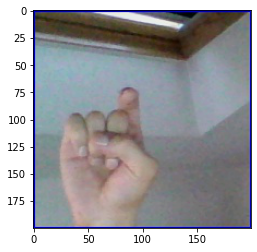

Image size is torch.Size([100, 3, 200, 200])
Ground truth H


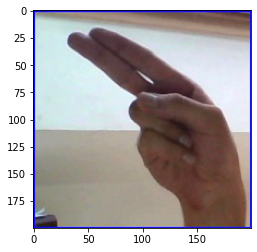

Image size is torch.Size([100, 3, 200, 200])
Ground truth Y


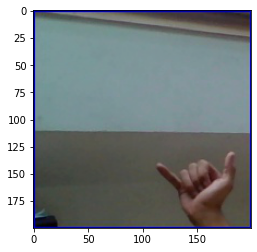

Image size is torch.Size([100, 3, 200, 200])
Ground truth U


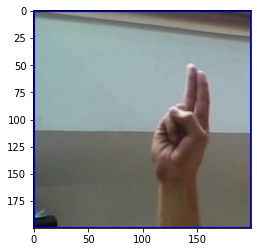

Image size is torch.Size([100, 3, 200, 200])
Ground truth V


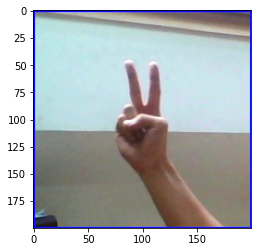

In [9]:
for i in range(5):
    for img, label in train_loader:
        print("Image size is {0}".format(img.shape))
        print('Ground truth', classes[label[0]])
        plt.imshow(img[0].permute(1, 2, 0))
        plt.show()
        break

#### Defining Neural Network architecture to train the model

#### 2 CNN hidden layers

In [14]:
class Neural_Net_1(nn.Module):
    def __init__(self):
        super(Neural_Net_1,self).__init__()
        self.NN_1_feature_extract=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            
            nn.Conv2d(16,32,kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2)
        )

        self.classify=nn.Sequential(
            nn.Linear(32*100*100,80),
            nn.Dropout(0.2),
            nn.BatchNorm1d(80),
            nn.Dropout(0.2),
            nn.Linear(80,29),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        feat_extract=self.NN_1_feature_extract(x)
        feat_extract=feat_extract.view(-1,32*100*100)
        classification=self.classify(feat_extract)
        return classification

#### Verifying the model parameters

In [15]:
Model_1=Neural_Net_1()
Model_1.cuda()

Neural_Net_1(
  (NN_1_feature_extract): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=320000, out_features=80, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=80, out_features=29, bias=True)
    (5): Softmax(dim=1)
  )
)

#### Setting up the loss function and optimizer

In [16]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(Model_1.parameters(),lr=0.01,weight_decay=0.0001)

#### Checking for availabity of GPU

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("The device in use is {}".format(device)) 

The device in use is cuda


#### Training the models

In [18]:
def Model_train(number_of_epochs, train_loader, Model, loss_function, optimizer):
    count=0
    for epoch in range(number_of_epochs):
        correct=0
        for images, labels in train_loader:
            count+=1
            images = images.cuda()
            labels = labels.cuda()
            outputs=Model(images)
            loss=loss_function(outputs, labels)
            # Back Propogation
            optimizer.zero_grad()
            loss.backward()
            # Update Weights (Optimize the model)
            optimizer.step()
            # Checking the performance
            predictions=torch.max(outputs,1)[1]
            correct+=(predictions==labels).cpu().sum().numpy()
        print("Epoch is: {0}, Loss is {1} and Accuracy is: {2}".format(epoch+1,loss.data,100*correct/len(train_loader.dataset)))

    print("Training finished")

In [19]:
Model_train(10, train_loader,Model_1,loss_function,optimizer)

Epoch is: 1, Loss is 3.1150712966918945 and Accuracy is: 23.867816091954023
Epoch is: 2, Loss is 3.048858642578125 and Accuracy is: 39.648275862068964
Epoch is: 3, Loss is 2.960470199584961 and Accuracy is: 43.91724137931035
Epoch is: 4, Loss is 2.9264185428619385 and Accuracy is: 46.47586206896552
Epoch is: 5, Loss is 3.009674310684204 and Accuracy is: 48.714942528735634
Epoch is: 6, Loss is 2.906771659851074 and Accuracy is: 49.50459770114943
Epoch is: 7, Loss is 2.875595808029175 and Accuracy is: 50.310344827586206
Epoch is: 8, Loss is 2.904895305633545 and Accuracy is: 50.38620689655173
Epoch is: 9, Loss is 2.8680973052978516 and Accuracy is: 50.48505747126437
Epoch is: 10, Loss is 2.9692189693450928 and Accuracy is: 50.766666666666666
Training finished


#### Single layer CNN

In [20]:
class Neural_Net_2(nn.Module):
    def __init__(self):
        super(Neural_Net_2,self).__init__()
        self.NN_2_feature_extract=nn.Sequential(
            nn.Conv2d(3,16,kernel_size=(5,5),padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
        )

        self.classify=nn.Sequential(
            nn.Linear(160000,128),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128,29),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        feat_extract=self.NN_2_feature_extract(x)
        feat_extract=feat_extract.view(-1,100*100*16)
        classification=self.classify(feat_extract)
        return classification

In [21]:
Model_2=Neural_Net_2()
Model_2.cuda()

Neural_Net_2(
  (NN_2_feature_extract): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=160000, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=29, bias=True)
    (5): Softmax(dim=1)
  )
)

In [22]:
loss_function_2=nn.CrossEntropyLoss()
optimizer_2=torch.optim.Adam(Model_2.parameters(),lr=0.01,weight_decay=0.0001)

In [23]:
Model_train(10, train_loader,Model_2,loss_function_2,optimizer_2)

Epoch is: 1, Loss is 3.0790696144104004 and Accuracy is: 23.995402298850575
Epoch is: 2, Loss is 3.099177360534668 and Accuracy is: 34.227586206896554
Epoch is: 3, Loss is 3.1014952659606934 and Accuracy is: 38.654022988505744
Epoch is: 4, Loss is 3.095076560974121 and Accuracy is: 40.90574712643678
Epoch is: 5, Loss is 2.918365240097046 and Accuracy is: 42.50919540229885
Epoch is: 6, Loss is 3.046694755554199 and Accuracy is: 44.297701149425286
Epoch is: 7, Loss is 3.0073013305664062 and Accuracy is: 44.765517241379314
Epoch is: 8, Loss is 2.9185903072357178 and Accuracy is: 45.50229885057471
Epoch is: 9, Loss is 2.942519426345825 and Accuracy is: 45.81609195402299
Epoch is: 10, Loss is 3.051652431488037 and Accuracy is: 46.248275862068965
Training finished


In [36]:
class Neural_Net_3(nn.Module):
    def __init__(self):
        super(Neural_Net_3,self).__init__()
        self.NN_2_feature_extract=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=(5,5),padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),

            nn.Conv2d(64,128,kernel_size=(5,5),padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=(5,5),padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
        )

        self.classify=nn.Sequential(
            nn.Linear(256*25*25,256),
            nn.Dropout(0.2),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256,29),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        feat_extract=self.NN_2_feature_extract(x)
        feat_extract=feat_extract.view(-1,25*25*256)
        classification=self.classify(feat_extract)
        return classification

In [37]:
Model_3=Neural_Net_3()
Model_3.cuda()

Neural_Net_3(
  (NN_2_feature_extract): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=160000, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2)

In [26]:
loss_function_3=nn.CrossEntropyLoss()
optimizer_3=torch.optim.Adam(Model_3.parameters(),lr=0.01,weight_decay=0.00001)

In [27]:
class Neural_Net_4(nn.Module):
    def __init__(self):
        super(Neural_Net_4,self).__init__()
        self.NN_4_feature_extract=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=(3,3),padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),

            nn.Conv2d(64,128,kernel_size=(3,3),padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
            
            nn.Conv2d(128,256,kernel_size=(3,3),padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride=2),
        )

        self.classify=nn.Sequential(
            nn.Linear(256*25*25,128),
            nn.Dropout(0.2),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128,29),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        feat_extract=self.NN_4_feature_extract(x)
        feat_extract=feat_extract.view(-1,25*25*256)
        classification=self.classify(feat_extract)
        return classification

In [28]:
Model_4=Neural_Net_4()
Model_4.cuda()

Neural_Net_4(
  (NN_4_feature_extract): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classify): Sequential(
    (0): Linear(in_features=160000, out_features=128, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2)

In [29]:
loss_function_4=nn.CrossEntropyLoss()
optimizer_4=torch.optim.Adam(Model_4.parameters(),lr=0.01,weight_decay=0.00001)

### As accuracy is increasing with increase in No.of hidden convolution layers, performing hyperparameter tuning only for 3 CNN hidden layers with change in learning rate and Kernel size

#### Kernel size (5 x 5)

In [30]:
learning_rates=[0.01,0.001]

In [40]:
for l_rate in learning_rates:
    loss_function_CNN=nn.CrossEntropyLoss()
    optimizer_CNN=torch.optim.Adam(Model_3.parameters(),lr=l_rate,weight_decay=0.0001)
    Model_train(7, train_loader,Model_3,loss_function_CNN,optimizer_CNN)

RuntimeError: CUDA out of memory. Tried to allocate 62.00 MiB (GPU 0; 15.90 GiB total capacity; 14.56 GiB already allocated; 49.75 MiB free; 14.94 GiB reserved in total by PyTorch)

#### Kernel size (3 x 3)

In [ ]:
for l_rate in learning_rates:
    loss_function_CNN_2=nn.CrossEntropyLoss()
    optimizer_CNN_2=torch.optim.Adam(Model_4.parameters(),lr=l_rate,weight_decay=0.0001)
    Model_train(7, train_loader,Model_4,loss_function_CNN_2,optimizer_CNN_2)

### Training the ResNet Model by varying learning rate

In [ ]:
resnet_model = torch.torchvision.models.resnet50(pretrained=True)
resnet_model

In [ ]:
for param in resnet_model.parameters():
    param.requires_grad = False

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary
resnet_model.to(device)
summary(resnet_model, (3, 200, 200), batch_size=100)

In [ ]:
for l_rate in learning_rates:
    loss_function_resnet=nn.CrossEntropyLoss()
    optimizer_resnet=torch.optim.Adam(resnet_model.parameters(),
                                      lr=l_rate,weight_decay=0.0001)
    Model_train(7, train_loader,resnet_model,
                loss_function_resnet,optimizer_resnet)